<a href="https://colab.research.google.com/github/YeJin-Choi88/segmemt-anything-v2/blob/main/segmentation(video).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

PyTorch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-mq2n_chr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-mq2n_chr
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 7e1596c0b6462eb1d1ba7e1492430fed95023598
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2024-08-22 08:11:33--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.102, 108.157.254.124, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897952466 (856M) [application/vnd.snesdev-pag

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [6]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [7]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

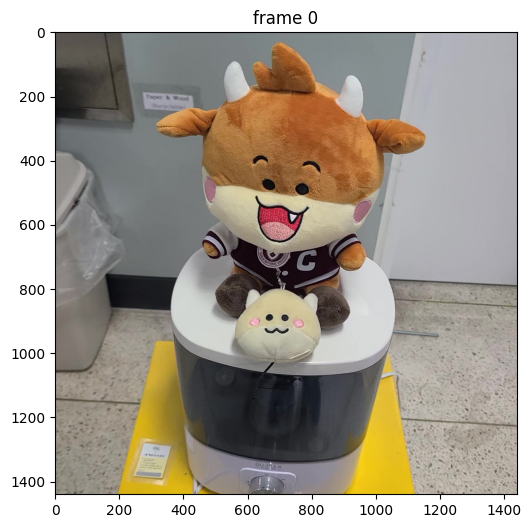

In [8]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/wowang"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [9]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 170/170 [00:11<00:00, 14.50it/s]


In [10]:
predictor.reset_state(inference_state)

/usr/local/lib/python3.10/dist-packages/sam2/sam2_video_predictor.py:873: UserWarning: /usr/local/lib/python3.10/dist-packages/sam2/_C.so: undefined symbol: _ZN3c1015SmallVectorBaseIjE8grow_podEPKvmm

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


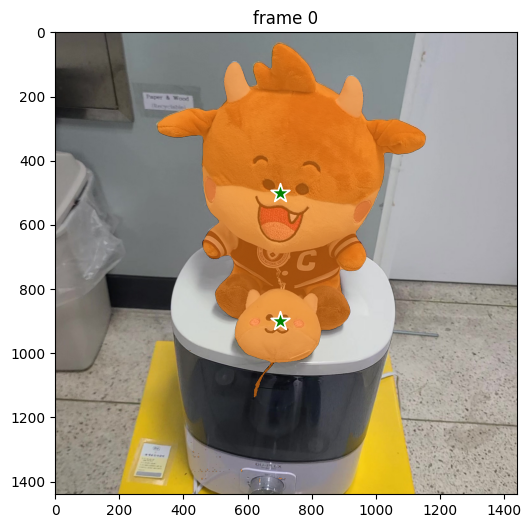

In [13]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (700,500) to get started
points = np.array([[700, 500],[700,900]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 170/170 [03:02<00:00,  1.08s/it]


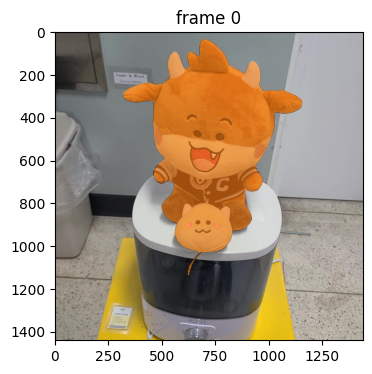

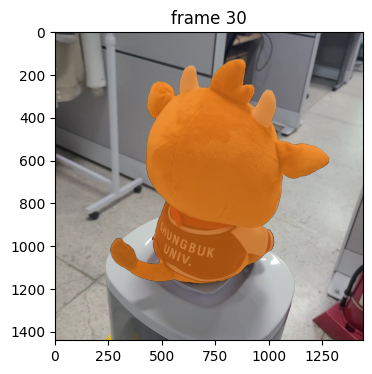

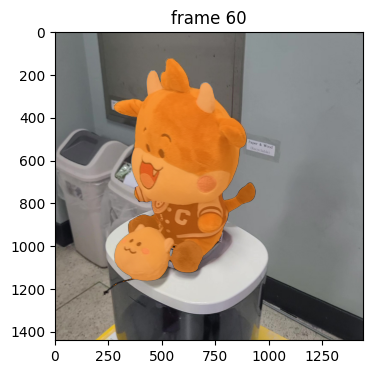

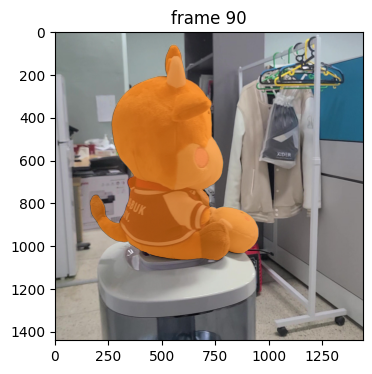

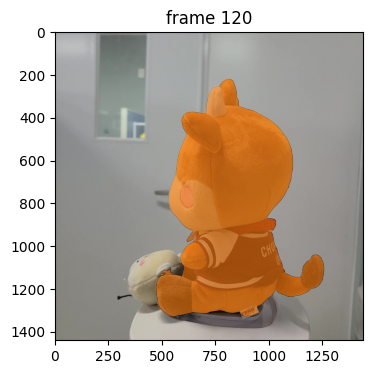

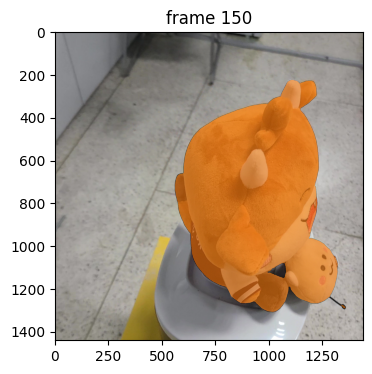

In [14]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

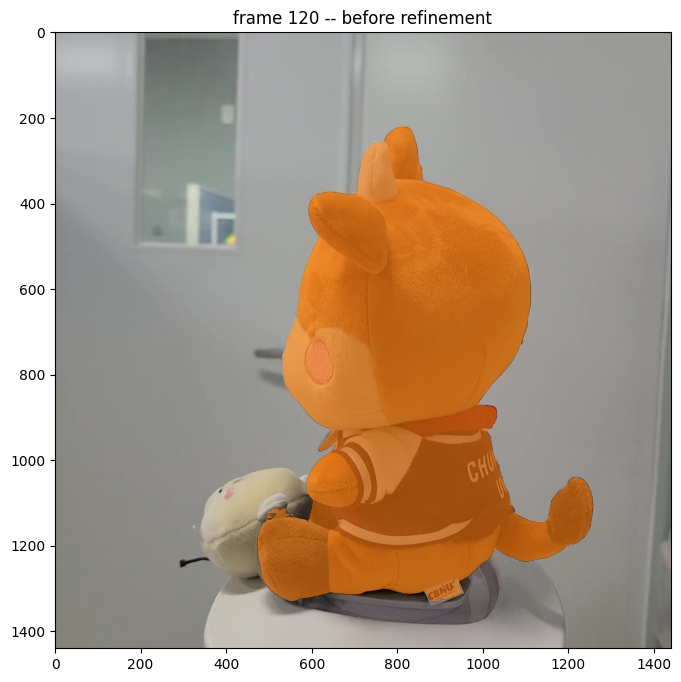

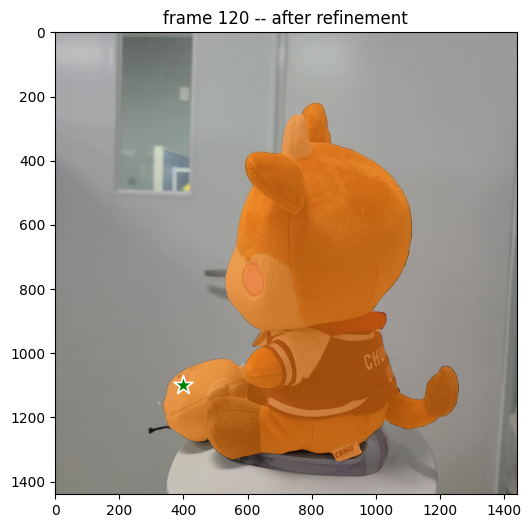

In [16]:
ann_frame_idx = 120  # further refine some details on this frame
ann_obj_id = 1  # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
points = np.array([[400, 1100]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, _, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

propagate in video: 100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


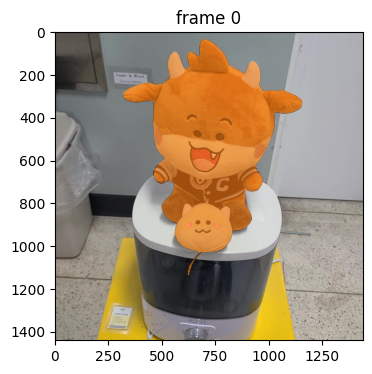

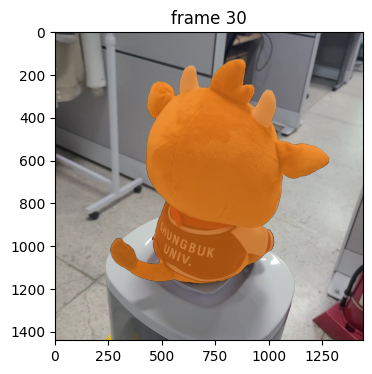

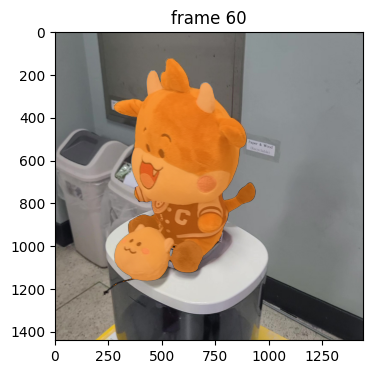

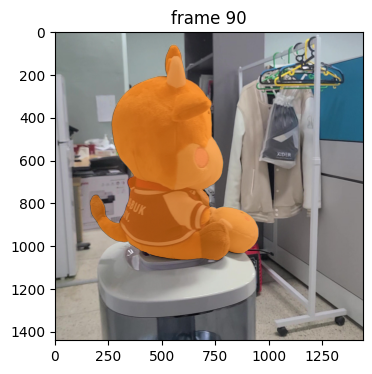

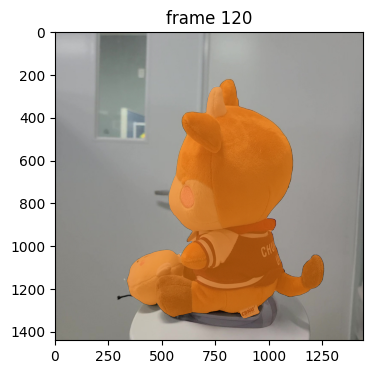

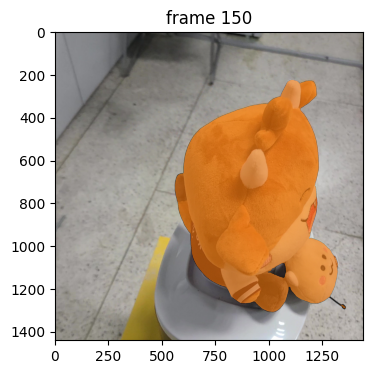

In [17]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)